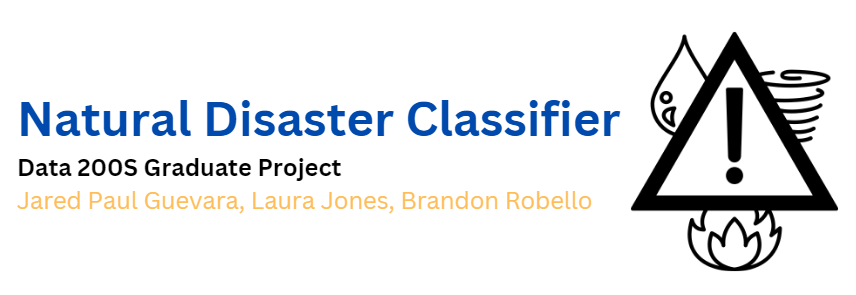


# Modeling - Task B: Classifying `hurricane-matthew` Damage Level


Modeling for Task B consists of the following tasks:

1. Loading libraries, utility functions, and data

2. Addressing class/label imbalance via under and oversampling:  
   a. RandomUnderSampler (RUS)

   b. RandomOverSampler (ROS)

   c. Adaptive synthetic oversampling (ADASYN)

   Each method consists of the following steps:

   - Visualizing label distribution
   - Fitting to a exploratory `RandomForestClassifier` to visualize feature importance, as well as print classification report and accuracy

3. Using a `LinearSVC` model:  
   a. Feature selection

   - Separating features into 3 categories: raw image features (dimensions, average pixel intensities), image processing features (Sobel/Gabor/LBP), and color coverage features
   - Splitting training data, scaling, and fitting to model to extract the set of features with the highest accuracy

   b. Hyperparameter tuning

   - Using `GridSearchCV` to find the best combination of features: C (regularization parameter), max iterations, and penalty type

   c. Training optimal model and generating training, validation, and cross validation predictions and scores

   - Number of cross-validation folds = 10

   d. Classification report and confusion matrices

   - Printing classification report that includes precision, recall, and F1 scores
   - Regular and normalized confusion matrices generated for both training and validation sets

4. Using a `RandomForestClassifier` model:  
   a. Feature selection

   b. Hyperparameter tuning

   - Tuning max_depth, max_features, and number of estimators using `GridSearchCV`

   c. Training optimal model and generating training, validation, and cross validation predictions and scores

   - Number of cross-validation folds = 10

   d. Classification report and confusion matrices

5. Summary of results and exporting best model for generating predictions


## 1. Loading libraries, utility functions, and data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN

In [2]:
def visualize_feature_distribution(feature_df, disaster_type):
    """
    Visualize the distribution of the summary statistics for each dataset.

    Args:
        feature_df (DataFrame): DataFrame where each row is a feature vector and each column is a feature.
    """
    feature_names = feature_df.columns

    for feature_name in feature_names:
        plt.figure(figsize=(10, 6))
        sns.histplot(feature_df[feature_name], kde=True, bins=20)
        plt.title(f'Distribution of {feature_name} of {disaster_type}')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.show()

def label_dist(disaster, labels):
    """
    Visualize the distribution of the labels for each dataset.

    Args:
        disaster (str): Disaster associated with images.
        labels (Series): Series of truth labels assigned to each image from a dataset
    """
    # Print statements of min and max
    print(f"Value counts for labels in {disaster} :\n{pd.Series(labels).value_counts().sort_index()}")

    # Create a histogram for label distribution with bins for each label
    plt.hist(labels, bins=[0, 1, 2, 3, 4], align='left', color='green', alpha=0.7)
    plt.title(f'Damage Label Distribution of {disaster}')
    plt.xlabel('Damage Labels')
    plt.ylabel('Frequency')
    plt.xticks([0, 1, 2, 3])  # Set x-ticks to correspond to the discrete labels

    # Adjust the layout
    plt.tight_layout()
    plt.show()

**Observing the training set label distribution:**


`task_B_df` head:


,image_matrix,disaster,label,height,width,aspect_ratio,total_pixels,avg_pixel_int,avg_red_pixel_int,avg_green_pixel_int,...,gabor_11_var,gabor_3_var,gabor_1_var,gabor_10_var,gabor_2_var,gabor_8_var,gabor_0_var,area of red pixels above 85,area of green pixels above 111,area of blue pixels above 102
0,[[[ 58 94 83]\n [ 60 97 86]\n [ 61 98 ...,hurricane-matthew,3,65,54,0.830769,3510,94.020703,75.702279,105.275783,...,0.000122,0.000132,0.001399,0.000019,0.000016,0.000184,0.000149,0.226211,0.290028,0.403419
1,[[[150 177 183]\n [147 174 182]\n [153 180 1...,hurricane-matthew,0,67,105,1.567164,7035,106.040938,88.451599,119.422886,...,0.000073,0.000179,0.003852,0.000005,0.000029,0.000064,0.000160,0.426866,0.460270,0.462118
2,[[[ 59 81 75]\n [ 53 75 69]\n [ 47 68 ...,hurricane-matthew,1,54,56,1.037037,3024,117.725198,111.971561,122.160714,...,0.000342,0.000296,0.005609,0.000076,0.000061,0.000447,0.000344,0.635251,0.510913,0.601852


`X_train'.columns:


Index(['height', 'width', 'aspect_ratio', 'total_pixels', 'avg_pixel_int',
       'avg_red_pixel_int', 'avg_green_pixel_int', 'avg_blue_pixel_int',
       'lbp_var', 'gabor_7_var', 'gabor_6_var', 'lbp_mean', 'sobel_mean',
       'gabor_5_var', 'gabor_4_var', 'sobel_var', 'gabor_9_var',
       'gabor_11_var', 'gabor_3_var', 'gabor_1_var', 'gabor_10_var',
       'gabor_2_var', 'gabor_8_var', 'gabor_0_var',
       'area of red pixels above 85', 'area of green pixels above 111',
       'area of blue pixels above 102'],
      dtype='object')

Value counts for labels in hurricane-matthew :
label
0    2138
1    4190
2    1217
3    1375
Name: count, dtype: int64


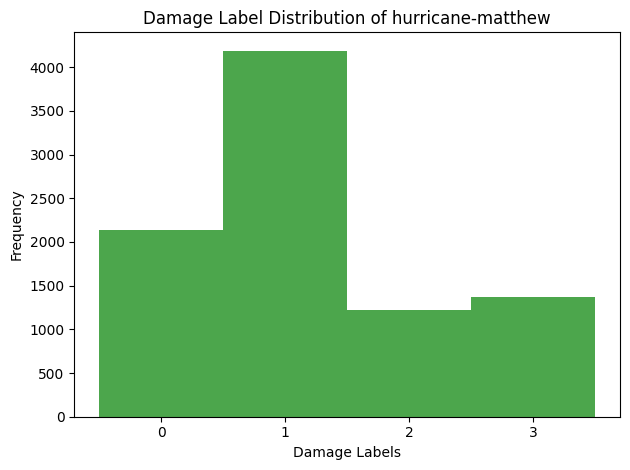

In [3]:
# Save Disaster of interest for task B
disaster = 'hurricane-matthew'

# Get dataset for hurricane-matthew
task_B_df = pd.read_csv('../data/task-data/task-B.csv')

print("`task_B_df` head:")
display(task_B_df.head(3))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(task_B_df.iloc[:,3:], task_B_df.iloc[:,2],
                                                    test_size=0.2, random_state=42)

print("`X_train'.columns:")
display(X_train.columns)

# Visualize Distribution
label_dist(disaster, y_train)

## 2. Addressing class/label imbalance


### 2a. Random Under Sampler (RUS)


Value counts for labels in hurricane-matthew :
label
0    1217
1    1217
2    1217
3    1217
Name: count, dtype: int64


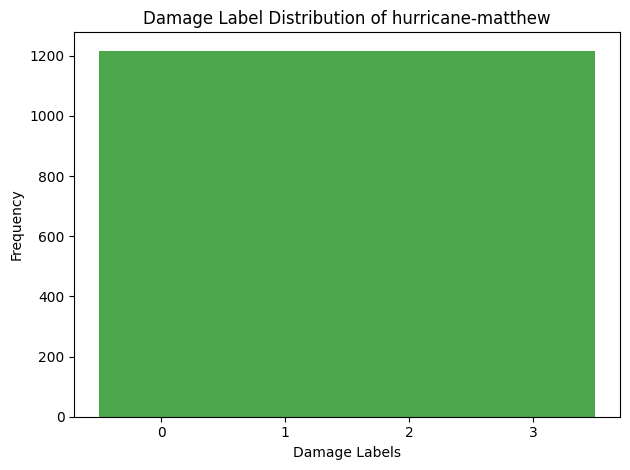

In [4]:
# Initialize the random under-sampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_rus_resampled)

Accuracy: 0.5091887046167638
              precision    recall  f1-score   support

           0       0.46      0.61      0.52       493
           1       0.68      0.45      0.54      1046
           2       0.26      0.37      0.31       327
           3       0.57      0.68      0.62       365

    accuracy                           0.51      2231
   macro avg       0.49      0.53      0.50      2231
weighted avg       0.55      0.51      0.52      2231



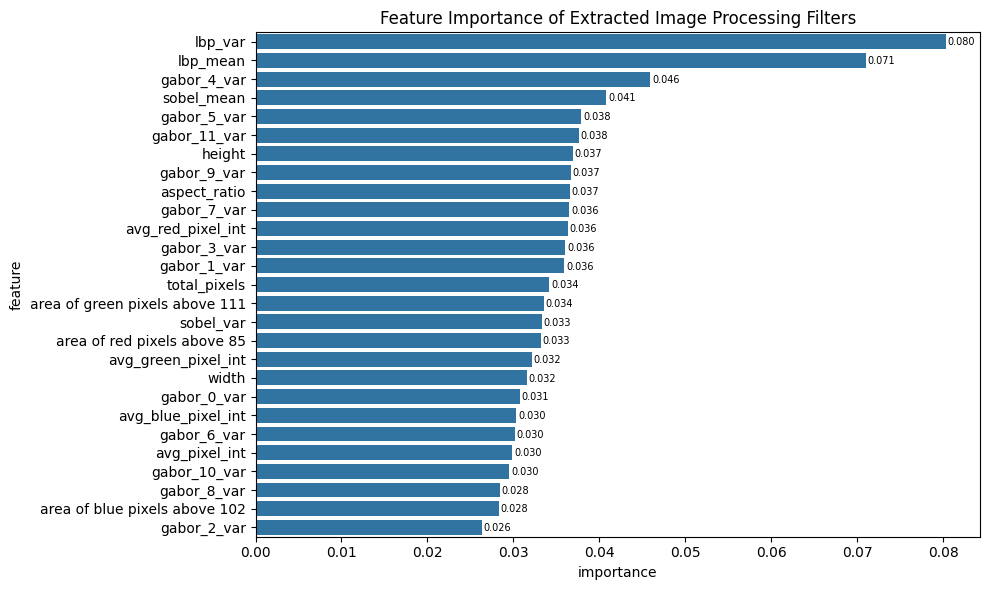

In [5]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the classifier
rf_classifier.fit(X_rus_resampled, y_rus_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_test)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_rus_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.6), fontsize=7)
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

### 2b. Random Over Sampler (ROS)


Value counts for labels in hurricane-matthew :
label
0    4190
1    4190
2    4190
3    4190
Name: count, dtype: int64


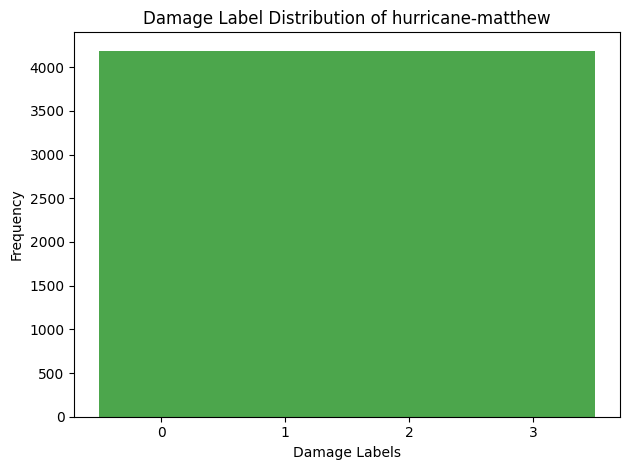

In [6]:
# Initialize the over-sampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_ros_resampled)

Accuracy: 0.5656656207978485
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       493
           1       0.64      0.68      0.66      1046
           2       0.30      0.18      0.22       327
           3       0.61      0.62      0.62       365

    accuracy                           0.57      2231
   macro avg       0.51      0.50      0.50      2231
weighted avg       0.55      0.57      0.55      2231



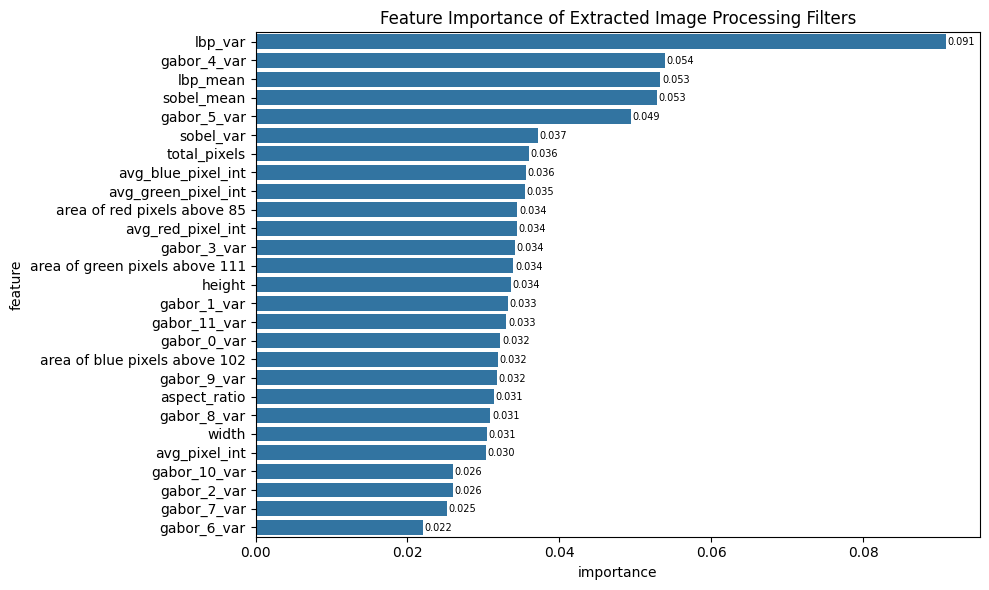

In [7]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the classifier
rf_classifier.fit(X_ros_resampled, y_ros_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_test)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_rus_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.6), fontsize=7)
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

### 2c. ADASYN


Value counts for labels in hurricane-matthew :
label
0    4208
1    4190
2    4200
3    4344
Name: count, dtype: int64


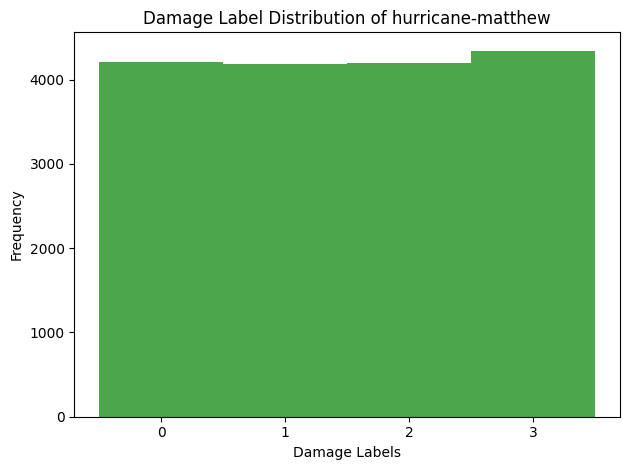

In [8]:
# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Resample the dataset using ADASYN
X_adasyn_resampled, y_adasyn_resampled = adasyn.fit_resample(X_train, y_train)

# Visualize Distribution
label_dist(disaster, y_adasyn_resampled)

Accuracy: 0.5719408337068579
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       493
           1       0.68      0.61      0.64      1046
           2       0.34      0.35      0.34       327
           3       0.60      0.70      0.64       365

    accuracy                           0.57      2231
   macro avg       0.53      0.55      0.54      2231
weighted avg       0.58      0.57      0.57      2231



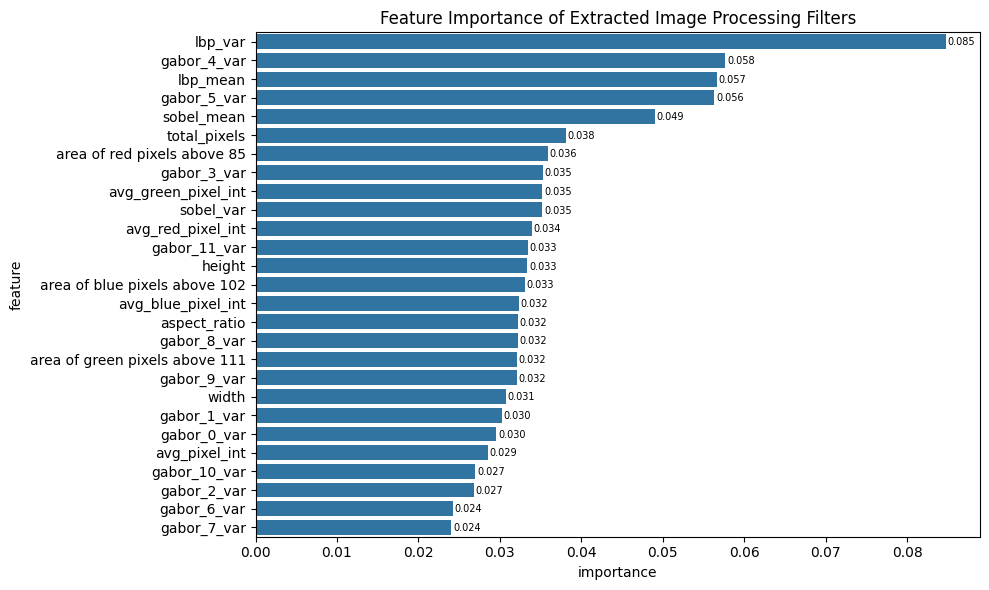

In [9]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_adasyn_resampled, y_adasyn_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Convert numeric damage_labels to strings for classification report
dmg_labels = [str(dl) for dl in set(y_adasyn_resampled)]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=dmg_labels))

# Get feature importances
importances = rf_classifier.feature_importances_

# Convert the importances into a more interpretable form
feature_importances = pd.DataFrame({
    'feature': X_adasyn_resampled.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width()+0.0002, p.get_y()+0.6), fontsize=7)
plt.title('Feature Importance of Extracted Image Processing Filters')
plt.tight_layout()
plt.show()

In [10]:
# Create a summary dataframe that compares between the different sampling techniques
sampling_comps = pd.DataFrame({'techniques' : ['original', 'RUS', 'ROS', 'ADASYN'],
                               'accuracy' : ['n/a', '0.515', '0.548', '0.564'],
                               '0' : [2138, 1217, 4190, 4214],
                               '1' : [4190, 1217, 4190, 4190],
                               '2' : [1217, 1217, 4190, 4226],
                               '3' : [1375, 1217, 4190, 4377]})
display(sampling_comps)

,techniques,accuracy,0,1,2,3
0,original,n/a,2138,4190,1217,1375
1,RUS,0.515,1217,1217,1217,1217
2,ROS,0.548,4190,4190,4190,4190
3,ADASYN,0.564,4214,4190,4226,4377


According to the results, ADASYN had the highest accuracy, while maintaining the largest number of samples to work with. We'll go ahead with ADASYN as our remedy to the imbalanced classes and train our models with it.


## 3. Using a `LinearSVC` model


**Loading X and y as the subset of the oversampled data:**


Dataframe shape before over-sampling: (11151, 27)
Dataframe shape after over-sampling: (21229, 27)
Value counts for labels in hurricane-matthew :
label
0    5170
1    5236
2    5296
3    5527
Name: count, dtype: int64


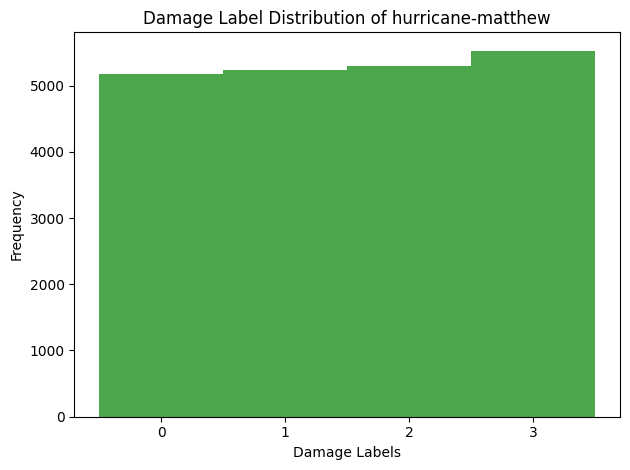

Top five rows of X:


,height,width,aspect_ratio,total_pixels,avg_pixel_int,avg_red_pixel_int,avg_green_pixel_int,avg_blue_pixel_int,lbp_var,gabor_7_var,...,gabor_11_var,gabor_3_var,gabor_1_var,gabor_10_var,gabor_2_var,gabor_8_var,gabor_0_var,area of red pixels above 85,area of green pixels above 111,area of blue pixels above 102
0,65,54,0.830769,3510,94.020703,75.702279,105.275783,101.084046,9.486493,1.449397e-05,...,0.000122,0.000132,0.001399,0.000019,0.000016,0.000184,0.000149,0.226211,0.290028,0.403419
1,67,105,1.567164,7035,106.040938,88.451599,119.422886,110.248330,6.510007,2.284809e-07,...,0.000073,0.000179,0.003852,0.000005,0.000029,0.000064,0.000160,0.426866,0.460270,0.462118
2,54,56,1.037037,3024,117.725198,111.971561,122.160714,119.043320,9.884637,2.858254e-05,...,0.000342,0.000296,0.005609,0.000076,0.000061,0.000447,0.000344,0.635251,0.510913,0.601852
3,114,124,1.087719,14136,117.736347,96.979697,128.503962,127.725382,6.942043,1.897601e-07,...,0.000048,0.000098,0.002696,0.000002,0.000018,0.000039,0.000100,0.549377,0.803339,0.797538
4,58,51,0.879310,2958,97.423372,87.179851,108.778905,96.311359,4.783794,5.867417e-07,...,0.000189,0.000206,0.003177,0.000013,0.000021,0.000112,0.000153,0.419202,0.390805,0.350913


In [11]:
# Show before and after changes to dataframe
print(f"Dataframe shape before over-sampling: {task_B_df.iloc[:, 3:].shape}")
adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(task_B_df.iloc[:, 3:], task_B_df.iloc[:, 2])
print(f"Dataframe shape after over-sampling: {X.shape}")
label_dist(disaster, y)

print(f'Top five rows of X:')
display(X.head())

### 3a. Feature selection


In [12]:
# LinearSVC Feature selection
def svc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [X.columns[0:8].to_list(), X.columns[8:24].to_list(), X.columns[24:].to_list(), X.columns[0:24].to_list(), X.columns[8:].to_list(), 
                        X.columns[0:8].to_list()+X.columns[24:].to_list(), X.columns.to_list()]

print(f'Best training score among feature combinations: {max(svc_feature_selection(feature_combinations))[1]:.3f}')

svc_best_params = max(svc_feature_selection(feature_combinations))[0]
print(f'Best parameters for LinearSVC: {svc_best_params}')

Best training score among feature combinations: 0.573
Best parameters for LinearSVC: ['lbp_var', 'gabor_7_var', 'gabor_6_var', 'lbp_mean', 'sobel_mean', 'gabor_5_var', 'gabor_4_var', 'sobel_var', 'gabor_9_var', 'gabor_11_var', 'gabor_3_var', 'gabor_1_var', 'gabor_10_var', 'gabor_2_var', 'gabor_8_var', 'gabor_0_var', 'area of red pixels above 85', 'area of green pixels above 111', 'area of blue pixels above 102']


Note: For the following results, we expect to see far worse accuracy scores compared to those from Task A. The classification of damage level is harder due to being multi-class, in addition to the differences between images being more subtle across damage levels. We will mainly be looking at average F1 score across both models to determine which one is best to go with.


### 3b. Hyperparameter tuning


In [13]:
# LinearSVC Grid Search (Runtime: ~20min)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', LinearSVC())])

param_grid = {'svc__C' : [0.01, 0.1, 1, 10, 100],
              'svc__max_iter' : [500, 1000, 2000, 3000],
              'svc__penalty' : ['l1', 'l2']}

best_X = X[svc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for LinearSVC model: {grid_search.best_params_}')

Best score: 0.573
Best hyperparameters for LinearSVC model: {'svc__C': 10, 'svc__max_iter': 3000, 'svc__penalty': 'l2'}


### 3c. Training optimal model


In [14]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('svc', LinearSVC(C=10, max_iter=3000))]) # default penalty is 'l2'

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
svc_train_preds = optimal_pipe.predict(X_train)
svc_train_score = optimal_pipe.score(X_train, y_train)
svc_val_preds = optimal_pipe.predict(X_val)
svc_val_score = optimal_pipe.score(X_val, y_val)
svc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {svc_train_score}')
print(f'Initial validation score: {svc_val_score}')
print(f'Average cross-validation score across 10 folds: {svc_cv_score.mean()}')

Initial training score: 0.5735735735735735
Initial validation score: 0.5779557230334432
Average cross-validation score across 10 folds: 0.5743094681782888


### 3d. Classification report and confusion matrices


              precision    recall  f1-score   support

           0      0.570     0.738     0.643      1022
           1      0.455     0.418     0.435      1049
           2      0.570     0.404     0.473      1061
           3      0.690     0.748     0.717      1114

    accuracy                          0.578      4246
   macro avg      0.571     0.577     0.567      4246
weighted avg      0.573     0.578     0.569      4246



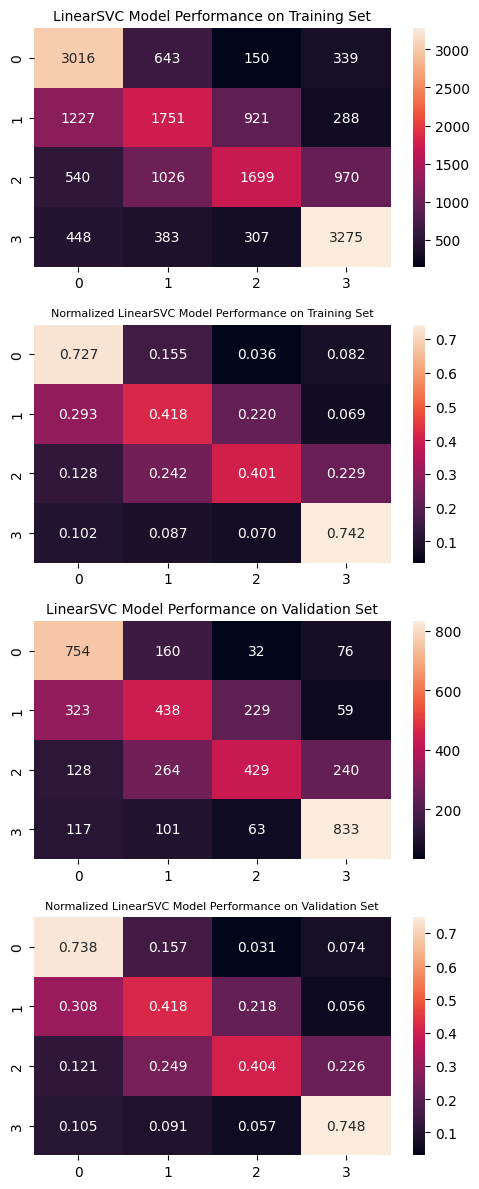

In [15]:
print(classification_report(y_val, svc_val_preds, digits=3))

plt.subplots(figsize=(5,12))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds), index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, svc_train_preds, normalize='true'),
                         index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds), index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.0f', annot=True)
plt.title('LinearSVC Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, svc_val_preds, normalize='true'),
                         index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.3f', annot=True)
plt.title('Normalized LinearSVC Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

## 4. Using a `RandomForestClassifier` model


### 4a. Feature selection


In [16]:
# RandomForestClassifier Feature selection
def rfc_feature_selection(features):
  feature_scores = []

  for combo in features:
    X_train, X_val, y_train, y_val = train_test_split(X[combo], y, test_size=0.2, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier())])
    feature_scores.append((combo, pipe.fit(X_train, y_train).score(X_train, y_train)))

  return feature_scores

feature_combinations = [X.columns[0:8].to_list(), X.columns[8:24].to_list(), X.columns[24:].to_list(), X.columns[0:24].to_list(), X.columns[8:].to_list(), 
                        X.columns[0:8].to_list()+X.columns[24:].to_list(), X.columns.to_list()]

print(f'Best training score among feature combinations: {max(rfc_feature_selection(feature_combinations))[1]:.3f}')

rfc_best_params = max(rfc_feature_selection(feature_combinations))[0]
print(f'Best parameters for RandomForestClassifier: {rfc_best_params}')

Best training score among feature combinations: 1.000
Best parameters for RandomForestClassifier: ['lbp_var', 'gabor_7_var', 'gabor_6_var', 'lbp_mean', 'sobel_mean', 'gabor_5_var', 'gabor_4_var', 'sobel_var', 'gabor_9_var', 'gabor_11_var', 'gabor_3_var', 'gabor_1_var', 'gabor_10_var', 'gabor_2_var', 'gabor_8_var', 'gabor_0_var', 'area of red pixels above 85', 'area of green pixels above 111', 'area of blue pixels above 102']


Interestingly, returning the max score from all possible feature combinations returns a 1.00, meaning perfect accuracy.


### 4b. Hyperparameter tuning


In [17]:
# RandomForestClassifier Grid Search (LONG RUNTIME WARNING ~1hr)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('rfc', RandomForestClassifier(random_state=42))])

param_grid = {'rfc__n_estimators' : [10, 100], # excluded 1000 to remedy runtime
              'rfc__max_features' : ['sqrt', 'log2', 0.33],
              'rfc__max_depth' : [1, 2, 5, 10]}

best_X = X[rfc_best_params]

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(best_X, y)

print(f'Best score: {grid_search.best_score_:.3f}')
print(f'Best hyperparameters for RandomForestClassifier model: {grid_search.best_params_}')

Best score: 0.624
Best hyperparameters for RandomForestClassifier model: {'rfc__max_depth': 10, 'rfc__max_features': 0.33, 'rfc__n_estimators': 100}


Again, like in Task A, the grid search for the `RandomForestClassifier` takes a very long time to run, which is a problem in replicating the results. We've removed the last choice for number of estimators, 1000, as that seemed to be the bottleneck for overall efficiency.


### 4c. Training optimal model


In [18]:
optimal_pipe = Pipeline([('scaler', StandardScaler()),
                         ('rfc', RandomForestClassifier(max_depth=10, max_features=0.33, n_estimators=100, random_state=42))])

X_train, X_val, y_train, y_val = train_test_split(best_X, y, test_size=0.2, random_state=42)
optimal_pipe.fit(X_train, y_train)
rfc_train_preds = optimal_pipe.predict(X_train)
rfc_train_score = optimal_pipe.score(X_train, y_train)
rfc_val_preds = optimal_pipe.predict(X_val)
rfc_val_score = optimal_pipe.score(X_val, y_val)
rfc_cv_score = cross_val_score(optimal_pipe, best_X, y, cv=10)
print(f'Initial training score: {rfc_train_score}')
print(f'Initial validation score: {rfc_val_score}')
print(f'Average cross-validation score across 10 folds: {rfc_cv_score.mean()}')

Initial training score: 0.7479832773950421
Initial validation score: 0.6307112576542628
Average cross-validation score across 10 folds: 0.6241003452603615


The scores across all sets are way higher compared to that of Task A, being a magnitude higher overall (0.01 difference in model scores vs. 0.1 difference). Task B seems to call for the `RandomForestClassifier` even more so than Task A.


### 4d. Classification report and confusion matrices


              precision    recall  f1-score   support

           0      0.645     0.675     0.660      1022
           1      0.577     0.533     0.554      1049
           2      0.566     0.527     0.546      1061
           3      0.713     0.781     0.746      1114

    accuracy                          0.631      4246
   macro avg      0.625     0.629     0.626      4246
weighted avg      0.626     0.631     0.628      4246



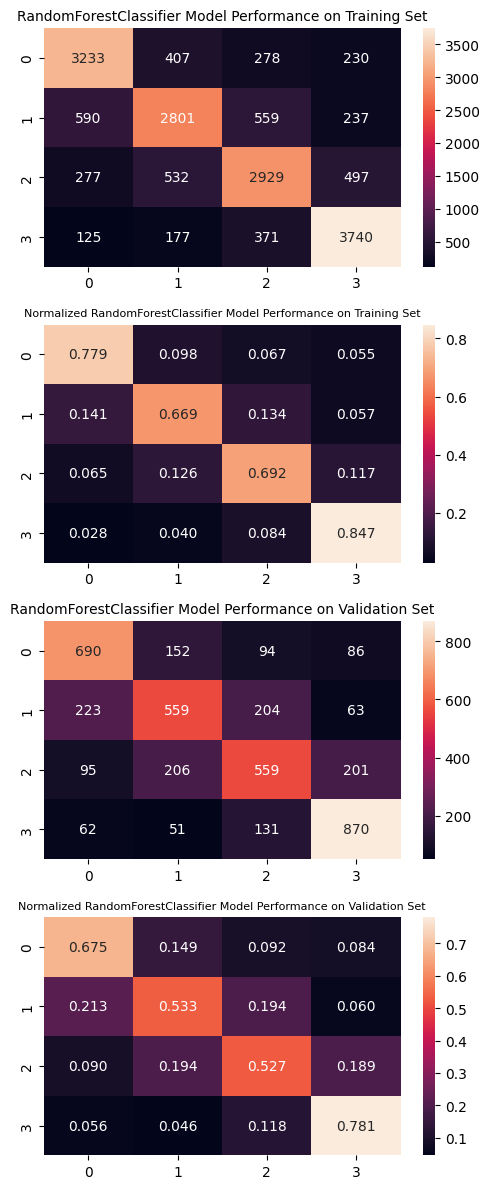

In [19]:
plt.subplots(figsize=(5,12))

print(classification_report(y_val, rfc_val_preds, digits=3))

plt.subplot(4, 1, 1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds), index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Training Set', fontsize=10)

plt.subplot(4, 1, 2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, rfc_train_preds, normalize='true'),
                         index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Training Set', fontsize=8)

plt.subplot(4, 1, 3)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds), index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.0f', annot=True)
plt.title('RandomForestClassifier Model Performance on Validation Set', fontsize=10)

plt.subplot(4, 1, 4)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, rfc_val_preds, normalize='true'),
                         index=[0, 1, 2, 3], columns=[0, 1, 2, 3]), fmt='.3f', annot=True)
plt.title('Normalized RandomForestClassifier Model Performance on Validation Set', fontsize=8)

plt.tight_layout()
plt.show()

## 5. Summary of results and exporting best model


In [20]:
print(f'LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: {svc_cv_score.mean()} vs. {rfc_cv_score.mean()}')
print(f'LinearSVC vs. RandomForestClassifier Training Scores: {svc_train_score} vs. {rfc_train_score}')
print(f'LinearSVC vs. RandomForestClassifier Validation Scores: {svc_val_score} vs. {rfc_val_score}')

LinearSVC vs. RandomForestClassifier Mean Cross-Validation Scores: 0.5743094681782888 vs. 0.6241003452603615
LinearSVC vs. RandomForestClassifier Training Scores: 0.5735735735735735 vs. 0.7479832773950421
LinearSVC vs. RandomForestClassifier Validation Scores: 0.5779557230334432 vs. 0.6307112576542628


In [21]:
with open('../models/task_B_model.pkl','wb') as f:
    pickle.dump(optimal_pipe,f)